In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

to_tensor = transforms.ToTensor()

def mnist_to_nxn_tensor(mnist_dataset, n=10, thresh=0.0):
    """
    
    args:
     n: (int) H and W of output array
     thresh: (float0-1) values below thresh will be set to zero
    """
    assert (thresh >= 0) and (thresh < 1)
    resized_dataset = []
    
    for img, label in mnist_dataset:
        # Resize the image to nxn
        resized_img = img.resize((n, n), Image.ANTIALIAS)
        resized_img = to_tensor(resized_img)

        
        # Convert the image to a binary tensor
        clamped = torch.clamp(resized_img, min=thresh, max=1.0) 
        #binary_tensor = torch.tensor(resized_img > thresh, dtype=torch.float32)
        
        # Add the binary tensor and the corresponding label to the resized dataset
        resized_dataset.append((clamped, label))
    
    return resized_dataset

image_shape = 8
thresh = 0.0

# Load the MNIST dataset and convert to binary nxn tensors
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)
resized_mnist_train = mnist_to_nxn_tensor(mnist_train, n=image_shape, thresh=thresh)
resized_mnist_test = mnist_to_nxn_tensor(mnist_test, n=image_shape, thresh=thresh)


/tmp/ipykernel_192570/2105624300.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((n, n), Image.ANTIALIAS)


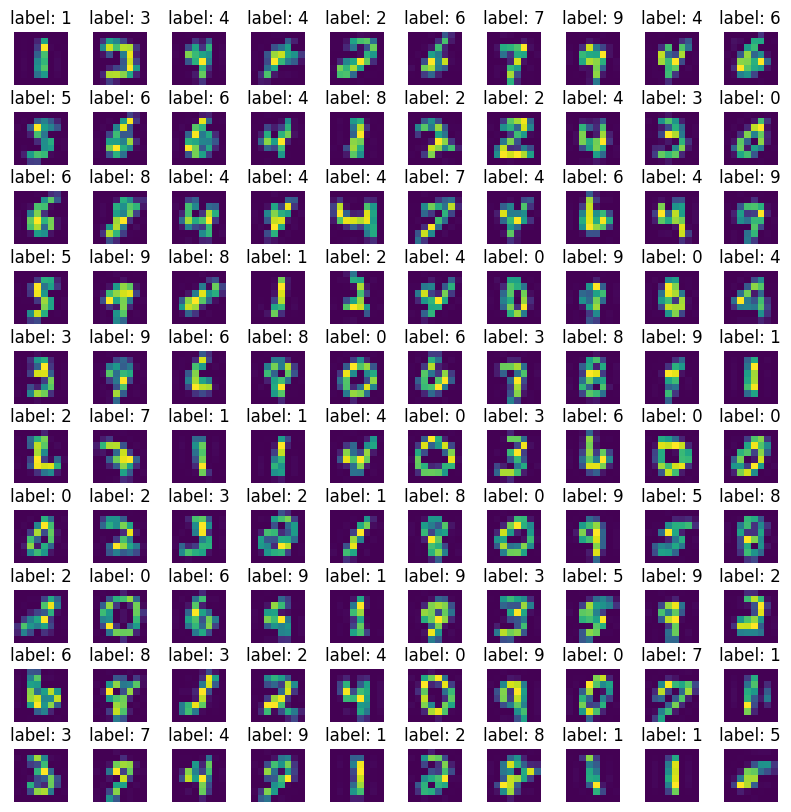

In [2]:
def show_grid(dataset, rows=10, cols=10):
    
    # Create a figure and axis object using subplots
    fig, ax = plt.subplots(rows, cols, figsize=(10,10))

    rand_idxs = np.random.randint(0,len(dataset), size=(10,10))
    
    # Loop through each subplot and plot the corresponding image
    for i in range(rows):
        for j in range(cols):
            idx = rand_idxs[i,j]
            image_tensor, label = dataset[idx]
            ax[i,j].imshow(image_tensor.numpy()[0])
            ax[i,j].axis('off')
            ax[i,j].set_title(f"label: {label}")

    # Display the plot
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
show_grid(resized_mnist_train)

In [25]:
import torch
import torch.nn as nn

class ConstrainedLinear(nn.Module):
    """A water friendly layer
    """
    def __init__(self, in_features, out_features):
        super(ConstrainedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.softmax = nn.Softmax(dim=0)
        
        # Initialize biases to positive.
        # they could still move into the -ve but for now
        # it's a good start. We'll need to change the optimizer if
        # we want to enforce this. Which we may nedd to do if we're
        # getting too many zero biases.
        nn.init.constant_(self.linear.bias, 0.1)

    def forward(self, x):
        # Normalize the weights of the linear layer (column-wise normalization)
        weight = self.linear.weight
        #normalized_weight = weight / weight.sum(dim=0, keepdim=True)
        normalized_weight = self.softmax(weight)

        # Apply the linear transformation with normalized weights
        x = torch.matmul(x, normalized_weight.t())#
        # Constrain the bias to positive values
        bias = self.linear.bias.clamp(min=0)
        
        # Subtract bias to effectivally offest ReLu
        return x - bias
    
class SimpleFCNN(nn.Module):
    def __init__(self, n):
        super(SimpleFCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = ConstrainedLinear(n * n, 20)
        self.output = ConstrainedLinear(20, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.hidden(x))
        x = self.output(x)

        return x


# Create the network
model = SimpleFCNN(image_shape)

# Sample input: a 5x5 tensor
input_tensor = torch.randn(1, image_shape, image_shape)

# Forward pass
output = model(input_tensor)
print("Output:", output)

Output: tensor([[0.1202, 0.1127, 0.1099, 0.1162, 0.1002, 0.1164, 0.0978, 0.1118, 0.1106,
         0.1100]], grad_fn=<SubBackward0>)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from PIL import Image



# SimpleFCNN and mnist_to_nxn_binary_tensor() from previous answers
batch_size=64

# Create data loaders
train_loader = DataLoader(resized_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(resized_mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Training parameters

epochs = 100
learning_rate = 0.5


# Create the network, loss function, and optimizer
model = SimpleFCNN(image_shape)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

best_acc = 0
best_epoch = 0
patience = 100


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    
    if accuracy > best_acc:
        best_acc = accuracy
        best_epoch = epoch
        count = 0
        print(f"saving at epoch: {epoch}")
        torch.save(model.state_dict(), "best_epoch.pth")
    else:
        count += 1
        if count >= patience:
            break
            
print("### DONE ###")
print(best_acc)
print(best_epoch)

Epoch 1/100, Loss: 2.2788
Accuracy: 14.19%
saving at epoch: 0
Epoch 2/100, Loss: 2.2445
Accuracy: 16.45%
saving at epoch: 1
Epoch 3/100, Loss: 2.2277
Accuracy: 13.59%
Epoch 4/100, Loss: 2.2161
Accuracy: 16.28%
Epoch 5/100, Loss: 2.1991
Accuracy: 15.29%
Epoch 6/100, Loss: 2.1751
Accuracy: 20.19%
saving at epoch: 5
Epoch 7/100, Loss: 2.1483
Accuracy: 25.20%
saving at epoch: 6
Epoch 8/100, Loss: 2.1199
Accuracy: 24.70%
Epoch 9/100, Loss: 2.0956
Accuracy: 25.78%
saving at epoch: 8
Epoch 10/100, Loss: 2.0754
Accuracy: 26.49%
saving at epoch: 9
Epoch 11/100, Loss: 2.0489
Accuracy: 32.49%
saving at epoch: 10
Epoch 12/100, Loss: 2.0178
Accuracy: 34.52%
saving at epoch: 11
Epoch 13/100, Loss: 1.9904
Accuracy: 34.50%
Epoch 14/100, Loss: 1.9669
Accuracy: 36.97%
saving at epoch: 13
Epoch 15/100, Loss: 1.9488
Accuracy: 38.56%
saving at epoch: 14
Epoch 16/100, Loss: 1.9325
Accuracy: 39.56%
saving at epoch: 15
Epoch 17/100, Loss: 1.9191
Accuracy: 40.32%
saving at epoch: 16
Epoch 18/100, Loss: 1.9084


In [ ]:
"""
    def forward(self, x):
        # Normalize the weights of the linear layer (column-wise normalization)
        weight = self.linear.weight
        normalized_weight = weight / weight.sum(dim=0, keepdim=True)

        # Apply the linear transformation with normalized weights
        x = torch.matmul(x, normalized_weight.t())#
        
        # Constrain the bias to positive values
        bias = self.linear.bias.clamp(min=0)
        
        return x + bias
"""

hidden_weight = model.hidden.linear.weight
hidden_normalized_weights = model.hidden.softmax(hidden_weight).detach().numpy()
print(hidden_normalized_weights[...,0])
print(hidden_normalized_weights[...,0].sum())
hidden_bias = model.hidden.linear.bias.clamp(min=0).detach().numpy()
print(hidden_bias)

# output_weight = model.output.linear.weight
# output_normalized_weights = (output_weight / output_weight.sum(dim=0, keepdim=True)).detach().numpy()
# print(output_normalized_weights[...,0].sum())
# output_bias = model.output.linear.bias.clamp(min=0).detach().numpy()
# print(output_bias)

In [ ]:

# x = torch.matmul(x, normalized_weight.t()) + self.linear.bias
w = model.hidden.linear.weight
print(w.shape)
print(w[...,1].sum())

w = w / w.sum(dim=0, keepdim=True)
print(w[...,1].sum())
print(w.shape)


In [46]:
#sum([ 0.0403, -0.0302,  0.1182, -0.0801,  0.0934])
w = model.hidden.linear.weight
w.shape
print(w[...,0])
print(sum([ 0.0832, -0.0126,  0.0837, -0.0121,  0.0069]))
w.sum(dim=0, keepdim=True)[0]

tensor([ 0.0832, -0.0126,  0.0837, -0.0121,  0.0069],
       grad_fn=<SelectBackward0>)
0.14909999999999998


tensor([ 1.4923e-01,  1.4158e-01, -1.3809e-01,  8.7606e-01, -1.9293e+00,
         9.5545e+00, -1.0354e+00,  1.7017e-01, -5.6540e-01,  1.0954e+00,
        -2.7357e+00, -6.3763e+00,  2.1645e+02, -7.3726e+01,  2.6713e+01,
        -1.9498e+00, -2.1631e+02,  5.2240e+02, -2.7175e+00, -6.3011e+00,
        -4.1139e+01, -2.8869e+00,  4.4181e-01, -3.2042e+00,  4.3716e-01,
        -1.3649e+00, -3.4649e+02, -1.3108e+02,  1.7490e+01,  2.8623e+01,
         4.9967e+02, -5.0640e-01,  4.5736e-01, -5.4729e+00,  1.1590e+01,
        -6.4774e+00,  1.1766e+01,  8.0681e-01, -6.7049e+00,  4.4222e-01,
         1.9976e+00, -1.4597e+00, -2.8641e+05,  1.1694e+01,  8.1560e-01,
         2.0764e+01,  2.7039e+00,  4.6150e+01,  9.2264e-01,  5.5640e+03,
         5.1538e-01,  8.4896e-01, -8.8977e-01,  1.1025e+01, -6.4622e+01,
        -6.5994e-01, -2.2230e+00,  2.3321e+00,  4.6088e-01, -3.3002e+03,
        -1.1770e+01, -8.8167e-01, -5.4432e+00,  1.0782e-01],
       grad_fn=<SelectBackward0>)

In [147]:
def predict(image_arr):
    flat = image_arr.flatten()
    x = np.matmul(flat, hidden_normalized_weights.T) + hidden_bias
    print(x)
    x = np.matmul(flat, output_normalized_weights.T) + output_bias
    logits = max(0, x)
    return np.argmax(logits)

In [148]:
image_tensor, label = resized_mnist_test[100]
image_arr = image_tensor.numpy()[0]
pred = predict(image_arr)

fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(image_arr)
ax.axis('off')
ax.set_title(f"label: {label} -- pred: {pred}")

# Display the plot
plt.show()

[ 1.1256018   0.9312454  -0.6536111   0.7550946   0.75204784 -0.09730887
  0.6692656  -0.07676393  0.4422591   0.6560366   0.90010214  0.10376377
  0.5893013   0.1523882   0.8733321   0.9807175   0.8481369   0.06789728
  0.65805674  1.2057732 ]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 100)

tensor(14167.8389, grad_fn=<SumBackward0>)

In [81]:
weight[0].shape

torch.Size([100])

In [84]:
x = torch.tensor([[1,2,3],[4,5,6]])
x.sum(dim=1)


tensor([ 6, 15])

In [87]:
weight[...,0].shape

torch.Size([10])

In [54]:
x = 10
w = 0.8
b = 2

x = x*w
print(x)

def belu(x, _b):
    return max(0, x-_b)
    
print(belu(x, b))



8.0
6.0


In [56]:
x = 10
w = 0.8
b = 2

x = x*w - b
print(x)
print(max(0, x))

6.0
6.0
